In [66]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import PromptTemplate
load_dotenv()

True

In [67]:
llm = ChatGroq(
    model=os.getenv("model"),
    api_key=os.getenv("api_key")
)

In [71]:
# state
import operator


class TweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

class EvaluationSchemea(BaseModel):
    evaluation : Literal["approved", "declined"] = Field(description="based upon on the post, the evaluation output should be approved or declined.")
    feedback : str = Field(description="feedback for the tweet")

format = PydanticOutputParser(pydantic_object=EvaluationSchemea)

    

In [72]:
def generator(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]
    
    # send generator_llm
    
    response = llm.invoke(messages).content
    # return response
    return {'tweet': response, 'tweet_history': [response]}



In [73]:
def evaluater(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]
    template = PromptTemplate(template="{message} \n {format_ins}", input_variables=["message"], partial_variables={'format_ins' : format.get_format_instructions})
    prompt = template.invoke({"message": messages})
    response = llm.invoke(prompt)
    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [74]:
def optimize(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [75]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

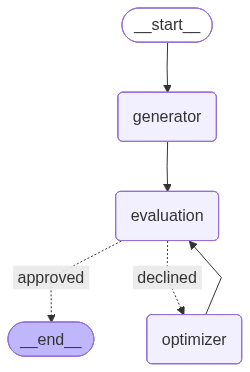

In [76]:
graph = StateGraph(TweetState)

graph.add_node("generator", generator)
graph.add_node("evaluation", evaluater)
graph.add_node("optimizer", optimize)

graph.add_edge(START, "generator")
graph.add_edge("generator", "evaluation")
graph.add_conditional_edges("evaluation", route_evaluation, {'approved' : END, "declined" : "optimizer"})
graph.add_edge("optimizer", "evaluation")
workflow = graph.compile()
workflow

In [82]:
print(workflow.invoke({'topic' : "I learned about MLOps"}))

AttributeError: 'AIMessage' object has no attribute 'evaluation'